In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.5 MB/s eta 0:00:00


**Problem statement:**

Sentiment analysis of the tweets from 2016 Presidential elections-3 categories of text-positive,negative or neutral

Dataset: https://www.kaggle.com/datasets/crowdflower/first-gop-debate-twitter-sentiment?resource=download

In [2]:
#Download the pretrained BERT model bert-base-uncased 

from transformers import BertModel
bert = BertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.2.attention.out_lin.weight', 'distilbert.transformer.layer.1.attention.v_lin.weight', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.q_lin.bias', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.3.ffn.lin1.weight', 'distilbert.transformer.layer.3.ffn.lin2.bias', 'distilbert.transformer.layer.2.ffn.lin1.bias', 'distilbert.transformer.layer.2.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.v_lin.bias', 'distilbert.transformer.layer.2.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.4.ffn.lin2.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transforme

In [3]:
#BERT tokenizer

from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


In [4]:
#Input formatting

text = "Jim Henson was a puppeteer"

sent_id = tokenizer.encode(text, 
                           # add [CLS] and [SEP] tokens
                           add_special_tokens=True,
                           # specify maximum length for the sequences                                  
                           max_length = 10,
                           truncation = True,
                           # add pad tokens to the right side of the sequence
                           pad_to_max_length='right')      
                 
# print integer sequence
print("Integer Sequence: {}".format(sent_id))

# convert integers back to text
print("Tokenized Text:",tokenizer.convert_ids_to_tokens(sent_id))

Integer Sequence: [101, 3958, 27227, 2001, 1037, 13997, 11510, 102, 0, 0]
Tokenized Text: ['[CLS]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]', '[PAD]', '[PAD]']


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [5]:
#Decode the tokenized text

decoded = tokenizer.decode(sent_id)
print("Decoded String: {}".format(decoded))

Decoded String: [CLS] jim henson was a puppeteer [SEP] [PAD] [PAD]


In [6]:
#Mask to avoid performing attention to padding token indices.
#Mask values: 1 for tokens NOT MASKED, 0 for MASKED tokens.

att_mask = [int(tok > 0) for tok in sent_id]
print("Attention Mask:",att_mask)

Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


In [7]:
import torch

In [8]:
#Understanding input and output

# convert lists to tensors
sent_id = torch.tensor(sent_id)
att_mask = torch.tensor(att_mask)
# reshaping tensor in form of (batch,text length)
sent_id = sent_id.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)
print(sent_id)

tensor([[  101,  3958, 27227,  2001,  1037, 13997, 11510,   102,     0,     0]])


In [9]:
# pass integer sequence to bert model
outputs = bert(sent_id, attention_mask=att_mask)

In [10]:
#unpack the ouput of bert model
# hidden states at each timestep
all_hidden_states = outputs[0]
# hidden states at first timestep ([CLS] token)
cls_hidden_state = outputs[1]
print("Shape of last hidden states:",all_hidden_states.shape)
print("Shape of CLS hidden state:",cls_hidden_state.shape)

Shape of last hidden states: torch.Size([1, 10, 768])
Shape of CLS hidden state: torch.Size([1, 768])


**For the dataset**

In [11]:
import pandas as pd

df = pd.read_csv('Sentiment.csv')

print(df.shape)

#13871 statements labelled with their corresponding sentiments: Negative, neutral or positive

(13871, 21)


In [12]:
df['text'].sample(5)

13845    RT @the818: Let's play "how fast can we distan...
1252     RT @DoriaBiddle: Jeb Bush: "Knowing what we kn...
12690    You would do a far better job @Frank_Underwood...
10835    Had enough...going to bed #GOPDebates http://t...
7319     #RickSantorum brings full crazy to GOP debate,...
Name: text, dtype: object

In [13]:
# class distribution
print(df['sentiment'].value_counts(normalize = True))

# saving the value counts to a list
class_counts = df['sentiment'].value_counts().tolist()

Negative    0.612285
Neutral     0.226516
Positive    0.161200
Name: sentiment, dtype: float64


In [14]:
import re

In [15]:
#text cleaning

def preprocessor(text):
  
  #convering text to lower case
  text = text.lower()

  #remove user mentions
  text = re.sub(r'@[A-Za-z0-9]+','',text)           
  
  #remove hashtags
  #text = re.sub(r'#[A-Za-z0-9]+','',text)         
  
  #remove links
  text = re.sub(r'http\S+', '', text)  
  
  #split token to remove extra spaces
  tokens = text.split()
  
  #join tokens by space
  return " ".join(tokens)

In [16]:
# perform text cleaning
df['clean_text']= df['text'].apply(preprocessor)
# save cleaned text and labels to a variable
text   = df['clean_text'].values
labels = df['sentiment'].values
print(text[50:55])

['rt : the best and worst from the #gopdebate'
 'rt : .: big moments were vs. , and reaction to women question. #kellyfil…'
 "rt : here's a question, why in the hell are women &amp; our body parts even in this debate? foh, stop it, it's not 1965 wtf #gopdebate…"
 "americans getting beheaded overseas and is worried whether calls rosie o'donnell fat? #gopdebate"
 "rt : i won't defend , they were far from fair or balanced last night, but name calling is juvenile. #gopdebate"]


In [17]:
#Prepare output data

#importing label encoder
from sklearn.preprocessing import LabelEncoder
#define label encoder
le = LabelEncoder()
#fit and transform target strings to a numbers
labels = le.fit_transform(labels)
print(le.classes_)
print(labels)

['Negative' 'Neutral' 'Positive']
[1 2 1 ... 2 0 2]


Text(0.5, 1.0, 'Histogram: Length of sentences')

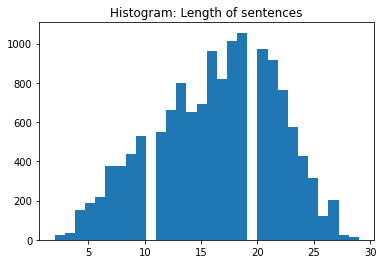

In [18]:
#prepare input data

import matplotlib.pyplot as plt
# compute no. of words in each tweet
num = [len(i.split()) for i in text]
plt.hist(num, bins = 30)
plt.title("Histogram: Length of sentences")

In [19]:
from tqdm import notebook
# create an empty list to save integer sequence
sent_id = []
# iterate over each tweet
for i in notebook.tqdm(range(len(text))):
  
  encoded_sent = tokenizer.encode(text[i],                      
                                  add_special_tokens = True,    
                                  max_length = 25,
                                  truncation = True,         
                                  pad_to_max_length='right')     
  # saving integer sequence to a list
  sent_id.append(encoded_sent)

  0%|          | 0/13871 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
#Creating attention masks

attention_masks = []
for sent in sent_id:
  att_mask = [int(token_id > 0) for token_id in sent]
  attention_masks.append(att_mask)

In [21]:
#Training and Validation data

# Use train_test_split to split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sent_id, labels, random_state=2018, test_size=0.1, stratify=labels)

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1, stratify=labels)

In [22]:
#Define data holders

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
# define a batch size
batch_size = 32

# Create the DataLoader for our training set.
#Dataset wrapping tensors.
train_data = TensorDataset(train_inputs, train_masks, train_labels)

#define a sampler for sampling the data during training
#random sampler samples randomly from a dataset 
#sequential sampler samples sequentially, always in the same order
train_sampler = RandomSampler(train_data)

#represents a iterator over a dataset. Supports batching, customized data loading order
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
#Dataset wrapping tensors.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

#define a sequential sampler 
#This samples data in a sequential order
validation_sampler = SequentialSampler(validation_data)

#create a iterator over the dataset
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [24]:
#create an iterator object
iterator = iter(train_dataloader)

#loads batch data
sent_id, mask, target=next(iterator)
print(sent_id.shape)

torch.Size([32, 25])


In [25]:
#pass inputs to the model
outputs = bert(sent_id,attention_mask=mask, return_dict=False) 
hidden_states = outputs[0]
CLS_hidden_state = outputs[1]
print("Shape of Hidden States:",hidden_states.shape)
print("Shape of CLS Hidden State:",CLS_hidden_state.shape)

Shape of Hidden States: torch.Size([32, 25, 768])
Shape of CLS Hidden State: torch.Size([32, 768])


**Model fine tuning**

In [26]:
#Step-1: Turning off the gradient of all the parameters

for param in bert.parameters():
    param.requires_grad = False

In [27]:
#Step-2: Defining Model Architecture

#importing nn module
import torch.nn as nn

class classifier(nn.Module):

    #define the layers and wrappers used by model
    def __init__(self, bert):
      
      #constructor
      super(classifier, self).__init__()

      #bert model
      self.bert = bert 

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      #dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)
      
      #dropout layer
      self.dropout = nn.Dropout(0.1)

      #relu activation function
      self.relu =  nn.ReLU()

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      all_hidden_states, cls_hidden_state = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      #pass CLS hidden state to dense layer
      x = self.fc1(cls_hidden_state)

      #Apply ReLU activation function
      x = self.relu(x)

      #Apply Dropout
      x = self.dropout(x)

      #pass input to the output layer
      x = self.fc2(x)
      
      #apply softmax activation
      x = self.softmax(x)

      return x

In [28]:
# define device before using it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
#create the model
model = classifier(bert)

#push the model to GPU, if available
model = model.to(device)

In [30]:
# push the tensors to GPU
sent_id = sent_id.to(device)
mask = mask.to(device)
target = target.to(device)

# pass inputs to the model
outputs = model(sent_id, mask)
print(outputs)

tensor([[-1.2372, -1.1191, -0.9591],
        [-1.2137, -1.0583, -1.0332],
        [-1.1904, -1.0847, -1.0276],
        [-1.1329, -1.1304, -1.0356],
        [-1.2185, -1.0321, -1.0553],
        [-1.1627, -1.1014, -1.0358],
        [-1.1633, -1.1051, -1.0318],
        [-1.2313, -1.0764, -1.0017],
        [-1.1710, -1.0896, -1.0396],
        [-1.2173, -1.0668, -1.0220],
        [-1.2208, -1.0915, -0.9961],
        [-1.2151, -1.0804, -1.0110],
        [-1.1661, -1.1127, -1.0223],
        [-1.1544, -1.0715, -1.0721],
        [-1.1398, -1.0737, -1.0836],
        [-1.2106, -1.0358, -1.0583],
        [-1.1952, -1.0593, -1.0479],
        [-1.1455, -1.1351, -1.0201],
        [-1.1894, -1.0265, -1.0867],
        [-1.2307, -1.0436, -1.0335],
        [-1.1932, -1.0593, -1.0497],
        [-1.1633, -1.0551, -1.0805],
        [-1.1773, -1.0540, -1.0690],
        [-1.1504, -1.0987, -1.0493],
        [-1.2238, -1.0351, -1.0478],
        [-1.1362, -1.1035, -1.0577],
        [-1.1991, -1.0765, -1.0279],
 

In [31]:
#Step-3: Define Optimizer and Loss function

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Text(0.5, 1.0, 'Class Distribution')

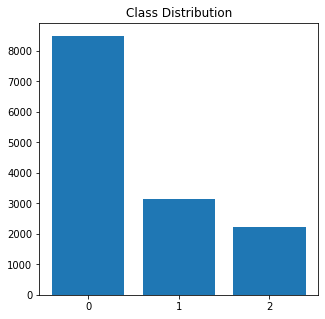

In [32]:
keys=['0','1','2']

# set figure size
plt.figure(figsize=(5,5))

# plot bat chart
plt.bar(keys,class_counts)

# set title
plt.title('Class Distribution')

In [33]:
#class weights-know the weights assigned to each of the labels

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

#class_weights = compute_class_weight('balanced', np.unique(labels), y=labels)
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(labels), y= labels)
print("Class Weights:",class_weights)

Class Weights: [0.54440912 1.471568   2.06782946]


In [34]:
# converting a list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
# transfer to GPU
weights = weights.to(device)
# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
#compute the loss
loss = cross_entropy(outputs, target)
print("Loss:",loss)

Loss: tensor(1.0814, device='cuda:0', grad_fn=<NllLossBackward0>)


**Model Training and evaluation**

In [35]:
import time
import datetime

# compute time in hh:mm:ss
def format_time(elapsed):
    # round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # format as hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_rounded))

Training: Epoch -> Batch -> Forward Pass -> Compute loss -> Backpropagate loss -> Update weights

In [36]:
#define a function for training the model
def train():
  
  print("\nTraining.....")  
  
  #set the model on training phase - Dropout layers are activated
  model.train()

  #record the current time
  t0 = time.time()

  #initialize loss and accuracy to 0
  total_loss, total_accuracy = 0, 0
  
  #Create a empty list to save the model predictions
  total_preds=[]
  
  #for every batch
  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 40 batches.
    if step % 40 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    sent_id, mask, labels = batch

    # Always clear any previously calculated gradients before performing a
    # backward pass. PyTorch doesn't do this automatically. 
    model.zero_grad()        

    # Perform a forward pass. This returns the model predictions
    preds = model(sent_id, mask)

    #compute the loss between actual and predicted values
    loss =  cross_entropy(preds, labels)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss = total_loss + loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    #The model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    #Accumulate the model predictions of each batch
    total_preds.append(preds)

  #compute the training loss of a epoch
  avg_loss     = total_loss / len(train_dataloader)
  
  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


**Evaluation phase**

Evaluation: Epoch -> Batch -> Forward Pass -> Compute loss

In [37]:
#define a function for evaluating the model
def evaluate():
  
  print("\nEvaluating.....")
  
  #set the model on training phase - Dropout layers are deactivated
  model.eval()

  #record the current time
  t0 = time.time()

  #initialize the loss and accuracy to 0
  total_loss, total_accuracy = 0, 0
  
  #Create a empty list to save the model predictions
  total_preds = []

  #for each batch  
  for step,batch in enumerate(validation_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels        
    sent_id, mask, labels = batch

    #deactivates autograd
    with torch.no_grad():
      
      # Perform a forward pass. This returns the model predictions
      preds = model(sent_id, mask)

      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      # Accumulate the validation loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value 
      # from the tensor.      
      total_loss = total_loss + loss.item()

      #The model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      #Accumulate the model predictions of each batch
      total_preds.append(preds)

  #compute the validation loss of a epoch
  avg_loss = total_loss / len(validation_dataloader) 

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

**Model training**

In [38]:
#Assign the initial loss to infinite
best_valid_loss = float('inf')

#create a empty list to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 5

#for each epoch
for epoch in range(epochs):
     
    print('\n....... epoch {:} / {:} .......'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    #accumulate training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")


....... epoch 1 / 5 .......

Training.....
  Batch    40  of    391.    Elapsed: 0:00:02.
  Batch    80  of    391.    Elapsed: 0:00:04.
  Batch   120  of    391.    Elapsed: 0:00:06.
  Batch   160  of    391.    Elapsed: 0:00:08.
  Batch   200  of    391.    Elapsed: 0:00:10.
  Batch   240  of    391.    Elapsed: 0:00:12.
  Batch   280  of    391.    Elapsed: 0:00:14.
  Batch   320  of    391.    Elapsed: 0:00:16.
  Batch   360  of    391.    Elapsed: 0:00:18.

Evaluating.....
  Batch    40  of     44.    Elapsed: 0:00:02.

Training Loss: 1.104
Validation Loss: 1.088

....... epoch 2 / 5 .......

Training.....
  Batch    40  of    391.    Elapsed: 0:00:02.
  Batch    80  of    391.    Elapsed: 0:00:04.
  Batch   120  of    391.    Elapsed: 0:00:06.
  Batch   160  of    391.    Elapsed: 0:00:08.
  Batch   200  of    391.    Elapsed: 0:00:10.
  Batch   240  of    391.    Elapsed: 0:00:12.
  Batch   280  of    391.    Elapsed: 0:00:14.
  Batch   320  of    391.    Elapsed: 0:00:16.
  Ba

**Model evaluation**

In [39]:
# load weights of best model
path='saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [40]:
# get the model predictions on the validation data
# returns 2 elements- Validation loss and Predictions
valid_loss, preds = evaluate()
print(valid_loss)


Evaluating.....
  Batch    40  of     44.    Elapsed: 0:00:02.
1.0743477588350123


In [41]:
from sklearn.metrics import classification_report,confusion_matrix

# Converting the log(probabities) into a classes
# Choosing index of a maximum value as class
y_pred = np.argmax(preds,axis=1)

# actual labels
y_true = validation_labels
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67       850
           1       0.37      0.40      0.39       314
           2       0.26      0.33      0.29       224

    accuracy                           0.54      1388
   macro avg       0.45      0.46      0.45      1388
weighted avg       0.56      0.54      0.55      1388



In [42]:
confusion_matrix(y_true,y_pred)

array([[542, 164, 144],
       [122, 127,  65],
       [ 99,  51,  74]])